In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Training and Splitting
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- Load your prepared dataset ---
try:
    df = pd.read_csv('ready_for_training.csv')
    print("Dataset 'ready_for_training.csv' loaded successfully!")
    print(f"Dataset contains {len(df)} rows.")
    # Fill any potential NaN values in processed_text, just in case
    df['processed_text'] = df['processed_text'].fillna('')
except FileNotFoundError:
    print("FATAL ERROR: 'ready_for_training.csv' not found. Please ensure it's in the same folder.")

# Display the first few rows to confirm
display(df.head())

Dataset 'ready_for_training.csv' loaded successfully!
Dataset contains 12880 rows.


,num_hyperlinks,num_suspicious_links,num_ip_urls,body_char_count,subject_char_count,urgency_keyword_count,num_capital_words,special_char_ratio,has_javascript,has_form_tag,processed_text,label
0,0,0,0,1262.0,51.0,0,0,0.132420,0,0,start date hourahead hour start date hourahead...,0
1,1,0,0,330.0,21.0,0,0,0.048295,0,0,league site available league site set site las...,0
2,18,0,0,3128.0,42.0,3,0,0.086408,0,0,urgent autopay payment unsuccessful http www t...,1
3,0,0,0,700.0,39.0,0,0,0.071622,0,0,midwest power team lotus note access tana woul...,0
4,0,0,0,305.0,13.0,0,0,0.031348,0,0,mitsui cacs hello please find attached cacs ne...,0


In [2]:
# The 'label' column is our target variable (y)
y = df['label']

# All other columns are our features (X)
X = df.drop('label', axis=1)

print("Features (X):")
display(X.head())
print("\nTarget (y):")
display(y.head())

Features (X):


,num_hyperlinks,num_suspicious_links,num_ip_urls,body_char_count,subject_char_count,urgency_keyword_count,num_capital_words,special_char_ratio,has_javascript,has_form_tag,processed_text
0,0,0,0,1262.0,51.0,0,0,0.132420,0,0,start date hourahead hour start date hourahead...
1,1,0,0,330.0,21.0,0,0,0.048295,0,0,league site available league site set site las...
2,18,0,0,3128.0,42.0,3,0,0.086408,0,0,urgent autopay payment unsuccessful http www t...
3,0,0,0,700.0,39.0,0,0,0.071622,0,0,midwest power team lotus note access tana woul...
4,0,0,0,305.0,13.0,0,0,0.031348,0,0,mitsui cacs hello please find attached cacs ne...



Target (y):


0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [3]:
# Identify which columns are numeric and which is text
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
text_feature = 'processed_text'

print(f"Numeric Features: {numeric_features}")
print(f"Text Feature: {text_feature}")

# Create the preprocessing pipeline
# 1. For text data: TfidfVectorizer to convert text into a matrix of TF-IDF features.
# 2. For numeric data: StandardScaler to scale features (important for logistic regression).
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), text_feature),
        ('scaler', 'passthrough', numeric_features) # Using 'passthrough' for now, can add StandardScaler if needed
    ],
    remainder='drop' # Drop any columns we haven't specified
)

print("\nPreprocessor configured successfully.")

Numeric Features: ['num_hyperlinks', 'num_suspicious_links', 'num_ip_urls', 'body_char_count', 'subject_char_count', 'urgency_keyword_count', 'num_capital_words', 'special_char_ratio', 'has_javascript', 'has_form_tag']
Text Feature: processed_text

Preprocessor configured successfully.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% of the data will be used for evaluation
    random_state=42, # Ensures the split is the same every time you run the code
    stratify=y       # Important for imbalanced datasets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Evaluation set size: {X_test.shape[0]} samples")

Training set size: 10304 samples
Evaluation set size: 2576 samples


In [5]:
# Create the full pipeline
# It first runs our preprocessor, then trains the classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the model on the training data
print("Training the Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)
print("Model training complete!")

Training the Logistic Regression model...
Model training complete!


Evaluating the model on the test set...

--- Evaluation Results ---
Balanced Accuracy: 0.9626
AUC Score: 0.9972
--------------------------

Generating Confusion Matrix...


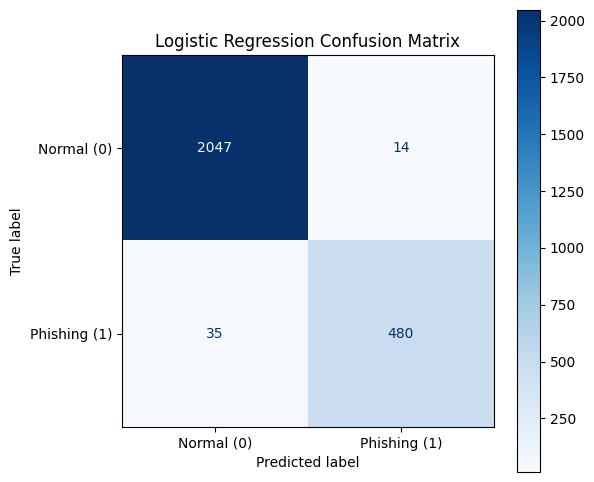

In [6]:
print("Evaluating the model on the test set...")

# Make predictions
y_pred = lr_pipeline.predict(X_test)
y_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1] # Probabilities needed for AUC

# --- Calculate Metrics ---
# 1. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
# 2. AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)

print("\n--- Evaluation Results ---")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("--------------------------\n")


# --- Visualize the Confusion Matrix ---
# The confusion matrix shows us exactly what types of errors the model is making.
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Phishing (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()